In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

import bioframe
from bioframe.tools import tsv
from bioframe.tools import bedtools

# some column name groups for future use:
cols=["chrom","start","end"]
cols1=["chrom1","start1","end1"]
cols2=["chrom2","start2","end2"]
# c_ctcf = ["chrom","start","end","direction"]
c_ctcf = ["chrom","start","end","strand"]

chromsizes = bioframe.fetch_chromsizes('hg38')
chromosomes = list(chromsizes.index)

In [110]:
# H1-hESC ctcf ChiP-seq from ENCODE: https://www.encodeproject.org/files/ENCFF904DSP/
# url = "https://www.encodeproject.org/files/ENCFF904DSP/@@download/ENCFF904DSP.bed.gz" # all peaks
url = "https://www.encodeproject.org/files/ENCFF821AQO/@@download/ENCFF821AQO.bed.gz" # optimal
# url = "https://www.encodeproject.org/files/ENCFF991GTC/@@download/ENCFF991GTC.bed.gz" # conservative
chip_ctcf = bioframe.read_table(url, schema='narrowPeak')
print(len(chip_ctcf))
display(chip_ctcf.head())

57199


,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr14,72786922,72787138,.,641,.,8.24814,-1.0,0.01128,108
1,chr10,101615106,101615322,.,944,.,8.25193,-1.0,0.01099,108
2,chr4,42768406,42768622,.,1000,.,8.30515,-1.0,0.00610,108
3,chr9,97039364,97039580,.,545,.,8.39904,-1.0,0.01074,108
4,chr16,68448009,68448225,.,655,.,8.45701,-1.0,0.02693,108


In [111]:
# get the CTCF-motif track:
motifs_sameer = "./supplement_tracks/sameer_motifscan_ctcf_fimo.txt.gz"
motifs = pd.read_table(motifs_sameer)
motifs = motifs[['sequence_name', 'start', 'stop', '# motif_id', 'score', 'strand']].rename(
    columns={'sequence_name': 'chrom', 'stop': 'end', '# motif_id': 'name'}).copy()


motifs.head()


,chrom,start,end,name,score,strand
0,chr2,231612721,231612739,MA0139.1,27.1967,+
1,chr16,84970710,84970728,MA0139.1,27.1311,-
2,chr3,98023412,98023430,MA0139.1,27.1311,-
3,chr5,137499397,137499415,MA0139.1,27.1311,-
4,chr4,5821785,5821803,MA0139.1,27.1311,+


In [116]:
with tsv(chip_ctcf[cols]) as a, tsv(motifs) as b:
    o = bedtools.intersect(a=a.name, b=b.name, wa=True, wb=True)
    o.columns = cols + [(c + '_m' if c in cols else c) for c in motifs.columns]
    grouped = o.groupby(['chrom', 'start', 'end'])
    ctcf_motif = o[o['score'] == grouped['score'].transform(max)]
    ctcf_motif = ctcf_motif.drop_duplicates(cols)

print(len(ctcf_motif))
ctcf_motif.head()

46879


,chrom,start,end,chrom_m,start_m,end_m,name,score,strand
0,chr19,10296103,10296319,chr19,10296091,10296109,MA0139.1,8.01639,+
1,chr6,28137040,28137256,chr6,28137131,28137149,MA0139.1,9.16393,-
2,chr17,58337723,58337939,chr17,58337770,58337788,MA0139.1,10.16390,+
3,chr19,54137912,54138128,chr19,54138117,54138135,MA0139.1,10.16390,-
5,chr20,32190073,32190289,chr20,32190195,32190213,MA0139.1,7.90164,-


In [117]:
# ls insulation/insulation-potential/

ips12 = "./insulation/insulation-potential/U54-ESC4DN-FA-DpnII-2017524-R1-R2.inspot.tab.bed"
iph12 = "./insulation/insulation-potential/U54-HFFc6-p17-p22-FA-DpnII-20170327_hg38.inspot.tab.bed"

dips12 = pd.read_table(ips12,names=c,header=None)
diph12 = pd.read_table(iph12,names=c,header=None)

dips12.head()

,chrom,start,end
0,chr1,10001,770000
1,chr1,780001,790000
2,chr1,860001,870000
3,chr1,900001,940000
4,chr1,950001,970000


In [118]:
# bed-intersect predicted insulated genomic regions with CTCF ...
flanking_inspot = 10000
insregions = dips12
insregions_flanked = dips12.copy()
insregions_flanked['start'] -= flanking_inspot
insregions_flanked['end'] += flanking_inspot

num_insregions = len(insregions)

with tsv(insregions_flanked) as _s, tsv(chip_ctcf[cols]) as _c:
    o = bedtools.intersect(a=_s.name, b=_c.name, wa=True,wb=True)
    o.columns = c + c2

# select only uniq insulated regions bound 
num_insregions_bound_ctcf = o.groupby(c).ngroups
    
print("{} of ins. regions have a CTCF-motif inside, out of {}, fraction: {}"\
          .format(num_insregions_bound_ctcf,num_insregions,num_insregions_bound_ctcf/num_insregions))
    

15330 of ins. regions have a CTCF-motif inside, out of 25177, fraction: 0.6088890654168487


In [119]:
# ls dots
s12 = "./dots/final_cloops_U54-ESC4DN-FA-DpnII-2017524-R1-R2.5000-10000.bedpe"
h12 = "./dots/final_cloops_U54-HFFc6-p17-p22-FA-DpnII-20170327_hg38.5000-10000.bedpe"
rao = "./dots/final_cloops_using_Rao_GM_primary_replicate.combined_5_10kb.10000000.named.txt"


ds12 = pd.read_table(s12)
dh12 = pd.read_table(h12)
drao = pd.read_table(rao)


chroms = ds12["chrom1"].unique()
display(ds12.head())
display(drao.head())

,chrom1,start1,end1,chrom2,start2,end2,obs.raw,cstart1,cstart2,c_label,c_size,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value
0,chr1,880000,890000,chr1,5650000,5660000,15,880000.0,5650000.0,0,1,0.443206,0.516720,0.705974,0.405552
1,chr1,1380000,1385000,chr1,1485000,1490000,49,1380000.0,1482500.0,2,2,20.022349,19.268067,21.153967,20.795501
2,chr1,1770000,1775000,chr1,8795000,8800000,114,1770000.0,8795000.0,3,1,0.155446,0.125364,0.050897,0.165955
3,chr1,1960000,1970000,chr1,2040000,2050000,346,1937000.0,2032000.0,9,10,170.640167,187.783053,179.274821,167.036607
4,chr1,3900000,3910000,chr1,4590000,4600000,59,3900000.0,4590000.0,22,1,23.507903,25.599774,30.460090,27.342046


,chrom1,start1,end1,chrom2,start2,end2,obs.raw,cstart1,cstart2,c_label,c_size,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value
0,chr1,920000,925000,chr1,995000,1000000,88,920000.0,995000.0,1,1,34.081317,46.856643,39.650605,33.355237
1,chr1,1050000,1060000,chr1,1180000,1190000,241,1060000.0,1180000.0,5,4,118.829008,119.957904,143.291883,108.196440
2,chr1,1340000,1345000,chr1,1440000,1445000,64,1340000.0,1440000.0,6,1,31.041486,38.971686,29.741747,30.184130
3,chr1,1585000,1590000,chr1,1645000,1650000,80,1582500.0,1645000.0,7,2,26.026317,24.995098,30.423218,25.347006
4,chr1,1710000,1715000,chr1,1835000,1840000,154,1715000.0,1835000.0,8,3,53.822133,81.246206,53.578020,74.403917


In [146]:
# need to create a dataframe of dots-bases
# first concat lest and right sides of the BEDPE file:
flanking_dots = 10000
dots_df = ds12

dotanchors = pd.concat([
                dots_df[cn].rename( # need to rename columns same way to concat:
                     columns={_cn:_c for _c,_cn in zip(c,cn)}) \
                        for cn in [c1,c2]])

dotanchors = dotanchors.sort_values(by=['chrom','start'])

with tsv(dotanchors) as _s:
    o = bedtools.merge(i=_s.name, d=1000)
    o.columns = c

dotanchors = o.copy()
dotanchors_flanked = o.copy()
dotanchors_flanked['start'] -= flanking_dots
dotanchors_flanked['end'] += flanking_dots
print("{} dots are formed by {} unique anchros, factor: {}" \
          .format(len(dots_df),len(dotanchors),len(dotanchors)/len(dots_df)))

5842 dots are formed by 9322 unique anchros, factor: 1.5956864087641218


In [147]:
# bed-intersect dots bases with CTCF ...

# # Example on how to work with bedtools wrapper from bioframe ...
# # use tsv - that creates temporary tsv-files from dataframes on the fly ...
with tsv(dotanchors_flanked[cols]) as _s, tsv(chip_ctcf[cols]) as _c:
    o = bedtools.intersect(a=_s.name, b=_c.name, wa=True,wb=True)
    o.columns = cols + [_+"_m" for _ in cols]
    # print(o.groupby(["chrom","start","end"]).ngroups)

num = o.groupby(["chrom","start","end"]).ngroups
print("{} of anchors have a CTCF-motif inside, out of {}, fraction: {}"\
          .format(num,len(dotanchors_flanked),num/len(dotanchors_flanked)))

7774 of anchors have a CTCF-motif inside, out of 9322, fraction: 0.8339412143316884


In [148]:
# bed-intersect dots bases with "predicted" insulation elements ...
with tsv(dotanchors_flanked[cols]) as _s, tsv(dips12) as _c:
    o = bedtools.intersect(a=_s.name, b=_c.name, wa=True,wb=True)
    o.columns = cols + cols1

num_inspot_dotbases_overlaps = o.groupby(cols).ngroups

print("{} of anchors overlap with predicted insulator regions, out of {}, fraction: {}"\
          .format(num_inspot_dotbases_overlaps,len(dotanchors),num_inspot_dotbases_overlaps/len(dotanchors)))
    

4997 of anchors overlap with predicted insulator regions, out of 9322, fraction: 0.5360437674318815


In [150]:
# bed-intersect dots with CTCF, left and right side separately ...

# # Example on how to work with bedtools wrapper from bioframe ...
# # use tsv - that creates temporary tsv-files from dataframes on the fly ...
with tsv(ds12[cols1]) as s, tsv(ctcf_motif[c_ctcf]) as c:
    o1 = bedtools.intersect(a=s.name, b=c.name, wa=True,wb=True)
    o1.columns = cols1 + c_ctcf
with tsv(ds12[cols2]) as s, tsv(ctcf_motif[c_ctcf]) as c:
    o2 = bedtools.intersect(a=s.name, b=c.name, wa=True,wb=True)
    o2.columns = cols2 + c_ctcf

# let's just look at the intersections ...
display(o2.head(2))
display(o1.head(2))

,chrom2,start2,end2,chrom,start,end,strand
0,chr1,2040000,2050000,chr1,2044968,2045078,-
1,chr1,2040000,2050000,chr1,2046585,2046706,-


,chrom1,start1,end1,chrom,start,end,strand
0,chr1,1960000,1970000,chr1,1960155,1960252,+
1,chr1,3900000,3910000,chr1,3900064,3900280,+


In [151]:
# merge original bedpe with the results of intersection on both sides ...
ds12_dd = ds12.merge(o1,how='outer',on=c1)[c1+c2+['strand']] \
              .merge(o2,how='outer',on=c2)[c1+c2+['strand_x','strand_y']]
# bedtools.intersect?
ds12_dd.head(5)

,chrom1,start1,end1,chrom2,start2,end2,strand_x,strand_y
0,chr1,880000,890000,chr1,5650000,5660000,NaN,NaN
1,chr1,1380000,1385000,chr1,1485000,1490000,NaN,NaN
2,chr1,1770000,1775000,chr1,8795000,8800000,NaN,NaN
3,chr1,1960000,1970000,chr1,2040000,2050000,+,-
4,chr1,1960000,1970000,chr1,2040000,2050000,+,-


In [153]:

# let's drop dots that have a CTCF motif at least in one of the anchors ...
ds12_ctcf = ds12_dd.dropna(how='all',subset=["strand_x","strand_y"])
# group by the dots again:
grp = ds12_ctcf.groupby(by=c1+c2)
# count groups, i.e. dots ...
print("{} dots have CTCF motif at least in one of the anchors, out of {} dots total: {}".format(len(grp),
                                                                                  len(ds12),
                                                                                  len(grp)/len(ds12) )
     )

# let's drop dots that does not have a CTCF motif in either of the anchors ...
ds12_ctcf = ds12_dd.dropna()
# group by the dots again:
grp = ds12_ctcf.groupby(by=c1+c2)
# count groups, i.e. dots ...
print("{} dots have CTCF motif in both anchors, out of {} dots total: {}".format(len(grp),
                                                                              len(ds12),
                                                                              len(grp)/len(ds12) )
     )

4322 dots have CTCF motif at least in one of the anchors, out of 5842 dots total: 0.7398151318041767
2206 dots have CTCF motif in both anchors, out of 5842 dots total: 0.37761040739472784


In [155]:
# let's select only those dots that have 1 CTCF motif per anchor
idx = np.concatenate([i for g,i in grp.groups.items() if len(i)==1])
# for those let's calculate directionality combinations:
ds12_dd.loc[idx].groupby(['strand_x',"strand_y"]).size()/len(ds12_dd.loc[idx])

strand_x  strand_y
+         +           0.089602
          -           0.799779
-         +           0.011062
          -           0.099558
dtype: float64

Text(0.5,0,'# of CTCF motif per dot')

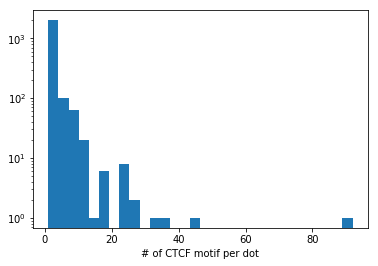

In [156]:
_ = plt.hist(grp.size(),bins=30,log=1)
ax = plt.gca()
ax.set_xlabel("# of CTCF motif per dot")